# Проект: Сборный проект —2

<b>Описание проекта</b>
<p>
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
</p>

**Цель:** оптимизировать управление персоналом за счет методов машинного обучения: снизить отток сотрудников и связанные с ним финансовые потери 

<b>Задачи:</b>
<ol>
<li>Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.</li>
<li>Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании</li>
</ol>

## Подключение необходимых библиотек

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install pandas==1.5.0 -q
!pip install phik -q

import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функции для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
#import shap
import phik
from sklearn.feature_selection import SelectKBest, f_classif

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

  You can safely remove it manually.


## Задача 1: Предсказание уровня удовлетворённости сотрудника

<b>Исходные данные:</b> данные о сотрудниках компании, предоставленные заказчиком (тренировочная выборка, тестовая выборка, целевой признак тестовой выборки)

## 1.1 Загрузка данных

Прочитаем исходные данные из файлов

In [2]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+'\\datasets\\'
train_job_satisfaction_rate_data= pd.read_csv(datasets_path+'train_job_satisfaction_rate.csv', sep=',')
test_features_data= pd.read_csv(datasets_path+'test_features.csv', sep=',')
test_target_job_satisfaction_rate_data= pd.read_csv(datasets_path+'test_target_job_satisfaction_rate.csv', sep=',')

##  1.2 Предобработка данных

Выведем общую информацию и первые 5 строк файла train_job_satisfaction_rate.csv для контроля загрузки и первого знакомства с данными

In [3]:
print(train_job_satisfaction_rate_data.info())
train_job_satisfaction_rate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Выведем общую информацию и первые 5 строк файла test_features.csv для контроля загрузки и оценки пропусков в данных

In [4]:
print(test_features_data.info())
test_features_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Выведем общую информацию и первые 5 строк файла test_target_job_satisfaction_rate.csv для контроля загрузки и оценки пропусков в данных

In [5]:
print(test_target_job_satisfaction_rate_data.info())
test_target_job_satisfaction_rate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


#### Проанализируем количество пропусков в данных по столбцам

In [6]:
train_job_satisfaction_rate_data.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

**Вывод: пропуски есть в столбцах "dept" (отдел, в котором работает сотрудник) и "level" (уровень занимаемой должности). Они же есть и в test_features_data. В пайплайне нужно будет их заполнить (предполагается использовать strategy='most_frequent').**

#### Поиск явных дубликатов

In [7]:
train_job_satisfaction_rate_data.duplicated().sum()

0

In [8]:
test_features_data.duplicated().sum()

0

In [9]:
test_target_job_satisfaction_rate_data.duplicated().sum()

0

**Вывод: явные дубликаты не найдены**

#### Поиск неявных дубликатов для значений, заданных строками-перечислениями

In [10]:
stub_str='not_specified'
print('Train data:')
for column in train_job_satisfaction_rate_data.select_dtypes(exclude='number').columns.tolist():
    print(f'{column}:{sorted(train_job_satisfaction_rate_data[column].fillna(stub_str).unique())}')

Train data:
dept:['hr', 'marketing', 'not_specified', 'purchasing', 'sales', 'technology']
level:['junior', 'middle', 'not_specified', 'sinior']
workload:['high', 'low', 'medium']
last_year_promo:['no', 'yes']
last_year_violations:['no', 'yes']


In [11]:
print('Test data:')
for column in test_features_data.select_dtypes(exclude='number').columns.tolist():
    print(f'{column}:{sorted(test_features_data[column].fillna(stub_str).unique())}')

Test data:
dept:[' ', 'hr', 'marketing', 'not_specified', 'purchasing', 'sales', 'technology']
level:['junior', 'middle', 'not_specified', 'sinior']
workload:[' ', 'high', 'low', 'medium']
last_year_promo:['no', 'yes']
last_year_violations:['no', 'yes']


Как выяснилось, в тестовых данных есть пустые значения для признаков "dept" и "workload". Это потребует дополнительной обработки в pipeline таких "необычных" значений

In [12]:
print('Test data (c заменой пустых строк)):')
for column in test_features_data.select_dtypes(exclude='number').columns.tolist():
    print(f'{column}:{sorted(test_features_data[column].fillna(stub_str).replace(" ", stub_str).unique())}')

Test data (c заменой пустых строк)):
dept:['hr', 'marketing', 'not_specified', 'purchasing', 'sales', 'technology']
level:['junior', 'middle', 'not_specified', 'sinior']
workload:['high', 'low', 'medium', 'not_specified']
last_year_promo:['no', 'yes']
last_year_violations:['no', 'yes']


In [13]:
workload_empty_cnt= len(test_features_data[test_features_data['workload']==" "])
print(f'Количество записей в тестовой выборке с пустым значением признака workload= {workload_empty_cnt})')

Количество записей в тестовой выборке с пустым значением признака workload= 1)


**Вывод: неявные дубликаты не найдены. Определено, что в тестовых данных есть пустые строки в категориальных признаках, которые надо иметь ввиду при моделировании. Особенно это касается признака workload, который не имеет пустого значения в тренировочной выборке, что может повлиять на результаты моделирования на тестовых данных (к счастью, в тестовых данных только 1 такая запись)**

## 1.3 Исследовательский анализ данных

#### Изучим числовые характеристики исходных данных о сотрудниках

In [14]:
train_job_satisfaction_rate_data.describe() 

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


**Анализ распределения значений числовых признаков, характеризующих сотрудников**

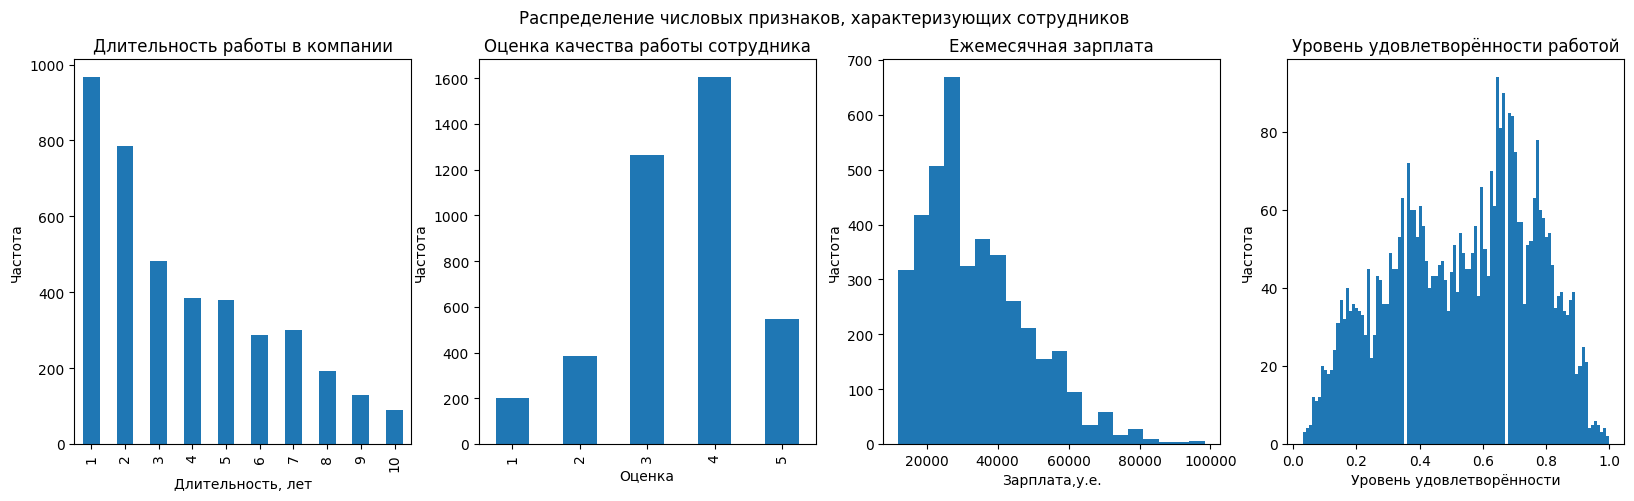

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle('Распределение числовых признаков, характеризующих сотрудников')
train_job_satisfaction_rate_data.groupby('employment_years')['employment_years'].count().plot(
ax=ax1,
kind='bar',
title='Длительность работы в компании')
ax1.set_ylabel('Частота')
ax1.set_xlabel('Длительность, лет')
train_job_satisfaction_rate_data.groupby('supervisor_evaluation')['supervisor_evaluation'].count().plot(
ax=ax2,
kind='bar',
title='Оценка качества работы сотрудника')
ax2.set_ylabel('Частота')
ax2.set_xlabel('Оценка')
train_job_satisfaction_rate_data['salary'].plot(
ax=ax3,
bins=20,
kind='hist',
title='Ежемесячная зарплата')
ax3.set_ylabel('Частота')
ax3.set_xlabel('Зарплата,у.е.')
train_job_satisfaction_rate_data['job_satisfaction_rate'].plot(
ax=ax4,
bins=100,
kind='hist',
title='Уровень удовлетворённости работой')
ax4.set_ylabel('Частота')
ax4.set_xlabel('Уровень удовлетворённости')
plt.show()

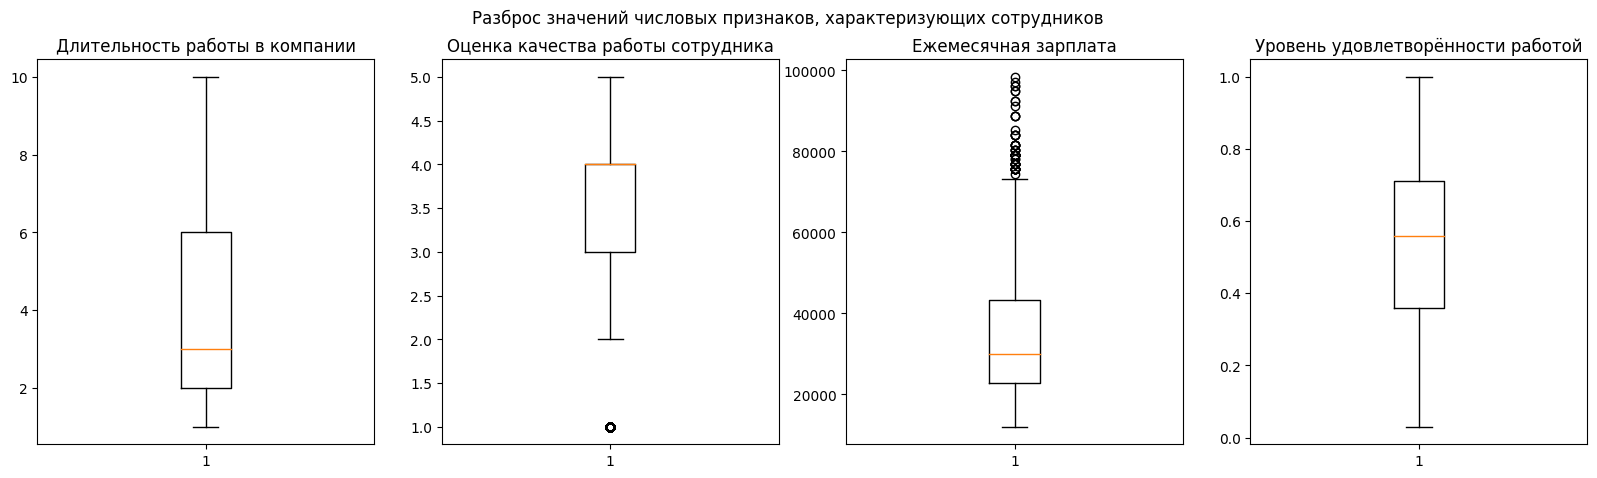

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle('Разброс значений числовых признаков, характеризующих сотрудников')
axes[0].boxplot(train_job_satisfaction_rate_data['employment_years'])
axes[1].boxplot(train_job_satisfaction_rate_data['supervisor_evaluation'])
axes[2].boxplot(train_job_satisfaction_rate_data['salary']) 
axes[3].boxplot(train_job_satisfaction_rate_data['job_satisfaction_rate']) 
axes[0].set_title('Длительность работы в компании')
axes[1].set_title('Оценка качества работы сотрудника')
axes[2].set_title('Ежемесячная зарплата')
axes[3].set_title('Уровень удовлетворённости работой')
plt.show()

In [17]:
def get_upper_mustache(df, char_name):
    quartiles = df[char_name].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    return quartiles[0.75] + 1.5*iqr
def get_upper_values_cnt(df, char_name):
    upper_level= get_upper_mustache(df, char_name)
    return df[df[char_name]>upper_level][char_name].count()
def get_lower_mustache(df, char_name):
    quartiles = df[char_name].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    return quartiles[0.25] - 1.5*iqr
def get_lower_values_cnt(df, char_name):
    lower_level= get_lower_mustache(df, char_name)
    return df[df[char_name]<lower_level][char_name].count()
anomal_values_cnt=get_upper_values_cnt(train_job_satisfaction_rate_data, 'salary')
print(f'Число аномально высоких значений зарплаты: {anomal_values_cnt}')
print(f'то есть {100*anomal_values_cnt/len(train_job_satisfaction_rate_data)} % от общего объема выборки')
anomal_values_cnt=get_lower_values_cnt(train_job_satisfaction_rate_data, 'supervisor_evaluation')
print(f'Число аномально низких значений оценки качества работы сотрудника: {anomal_values_cnt}')
print(f'то есть {100*anomal_values_cnt/len(train_job_satisfaction_rate_data)} % от общего объема выборки')

Число аномально высоких значений зарплаты: 60
то есть 1.5 % от общего объема выборки
Число аномально низких значений оценки качества работы сотрудника: 201
то есть 5.025 % от общего объема выборки


**Вывод по численным данным: исходы из анализа статистических показателей (среднее, медиана) и графиков разброса видно, что данные распределены не по нормальному закону распределения, и все численные признаки требуют масштабирования, либо нормализации (целевой признак по идее не нуждается в нормализации так как его значения распределены от 0 до 1). Значения оценок качества работы 5% сотрудников аномально низкие с точки зрения статистических показателей, но в сущности нет ничего невероятного в том, что 5% сотрудников так оцениваются их руководителями. Аналогично с 1,5% статистически "аномально высокой" зарплатой сотрудников - для небольшого числа высококвалифицированных специалистов и руководителей это тоже нормально и не требует внесения корректив в данные.**

#### Изучим категориальные характеристики исходных данных о сотрудниках

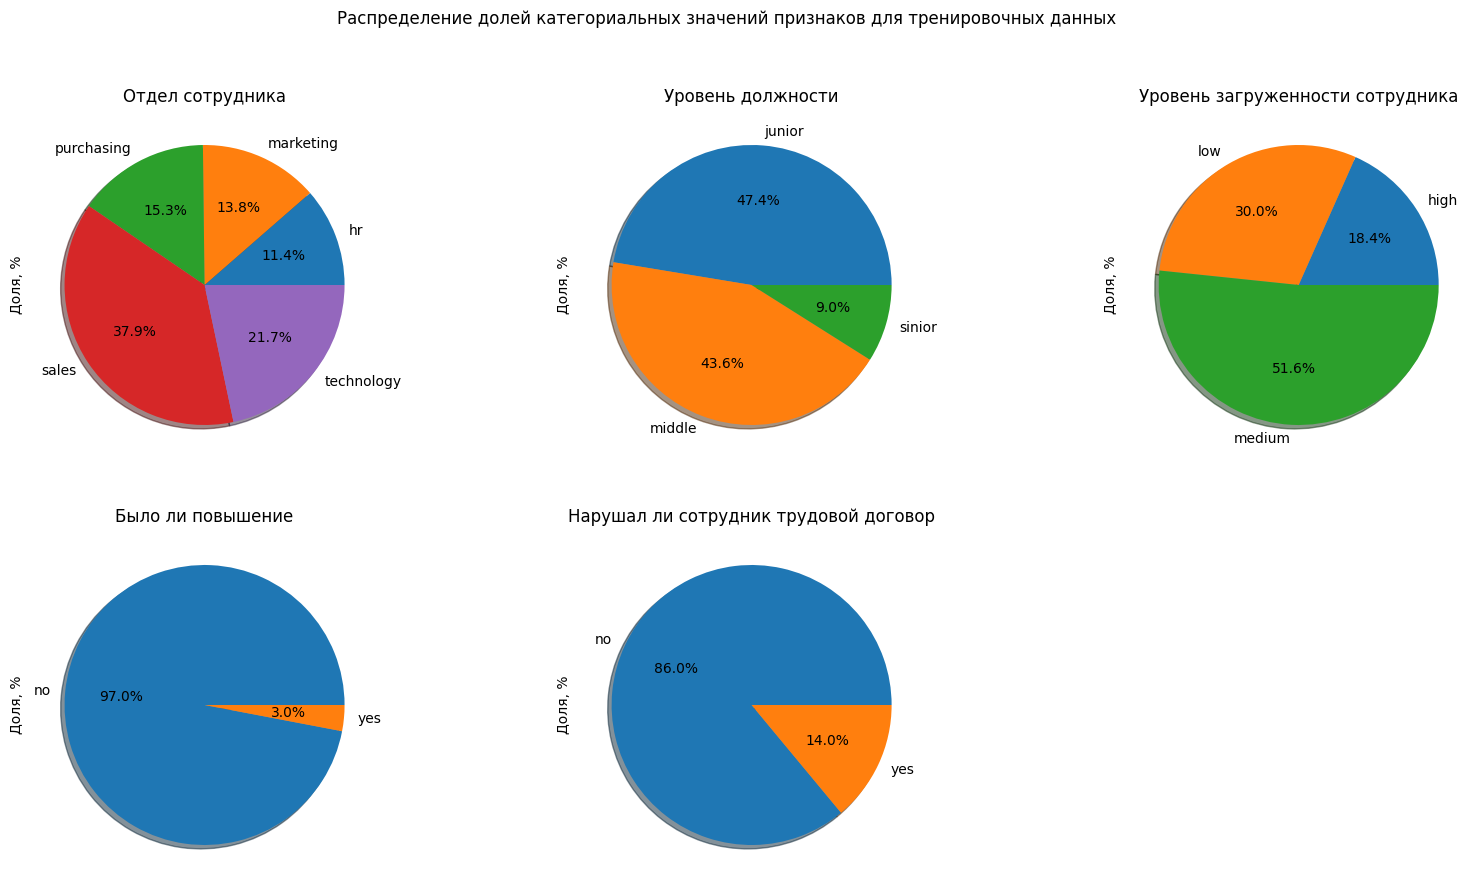

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Распределение долей категориальных значений признаков для тренировочных данных')
train_job_satisfaction_rate_data.groupby('dept')['dept'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Отдел сотрудника')
train_job_satisfaction_rate_data.groupby('level')['level'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень должности')
train_job_satisfaction_rate_data.groupby('workload')['workload'].count().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень загруженности сотрудника')
train_job_satisfaction_rate_data.groupby('last_year_promo')['last_year_promo'].count().plot(
ax=ax4,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Было ли повышение')
train_job_satisfaction_rate_data.groupby('last_year_violations')['last_year_violations'].count().plot(
ax=ax5,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Нарушал ли сотрудник трудовой договор')
ax6.set_visible(False)
plt.show()

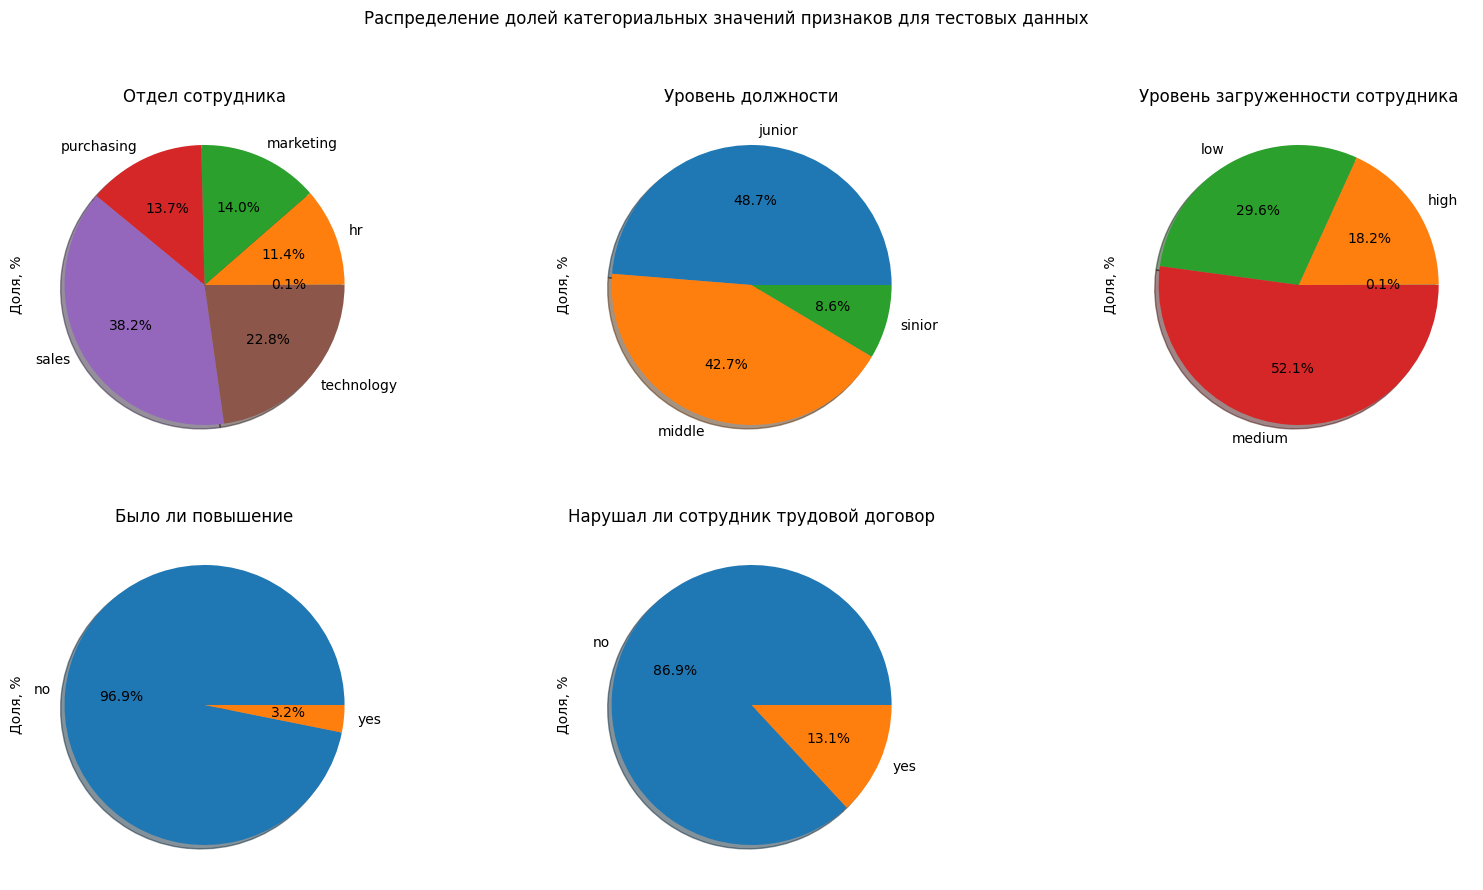

In [19]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Распределение долей категориальных значений признаков для тестовых данных')
test_features_data.groupby('dept')['dept'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Отдел сотрудника')
test_features_data.groupby('level')['level'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень должности')
test_features_data.groupby('workload')['workload'].count().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень загруженности сотрудника')
test_features_data.groupby('last_year_promo')['last_year_promo'].count().plot(
ax=ax4,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Было ли повышение')
test_features_data.groupby('last_year_violations')['last_year_violations'].count().plot(
ax=ax5,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Нарушал ли сотрудник трудовой договор')
ax6.set_visible(False)
plt.show()

**Вывод для категориальных признаков: категориальные данные не сбалансированы, при том достаточно сильно. Но баланс в тренировочной и тестовой выборке примерно соответствует (все отклонения в пределах 1%, что можно считать приемлемым), методов выравнивания баланса классов не требуется. Подготовка данных требует кодирования категориальных признаков с помощью OneHotEncoder или OrdinalEcnoder**

Построим матрицу корреляций для анализа взаимовлияния признаков и исключения возможной мультиколлинеарности

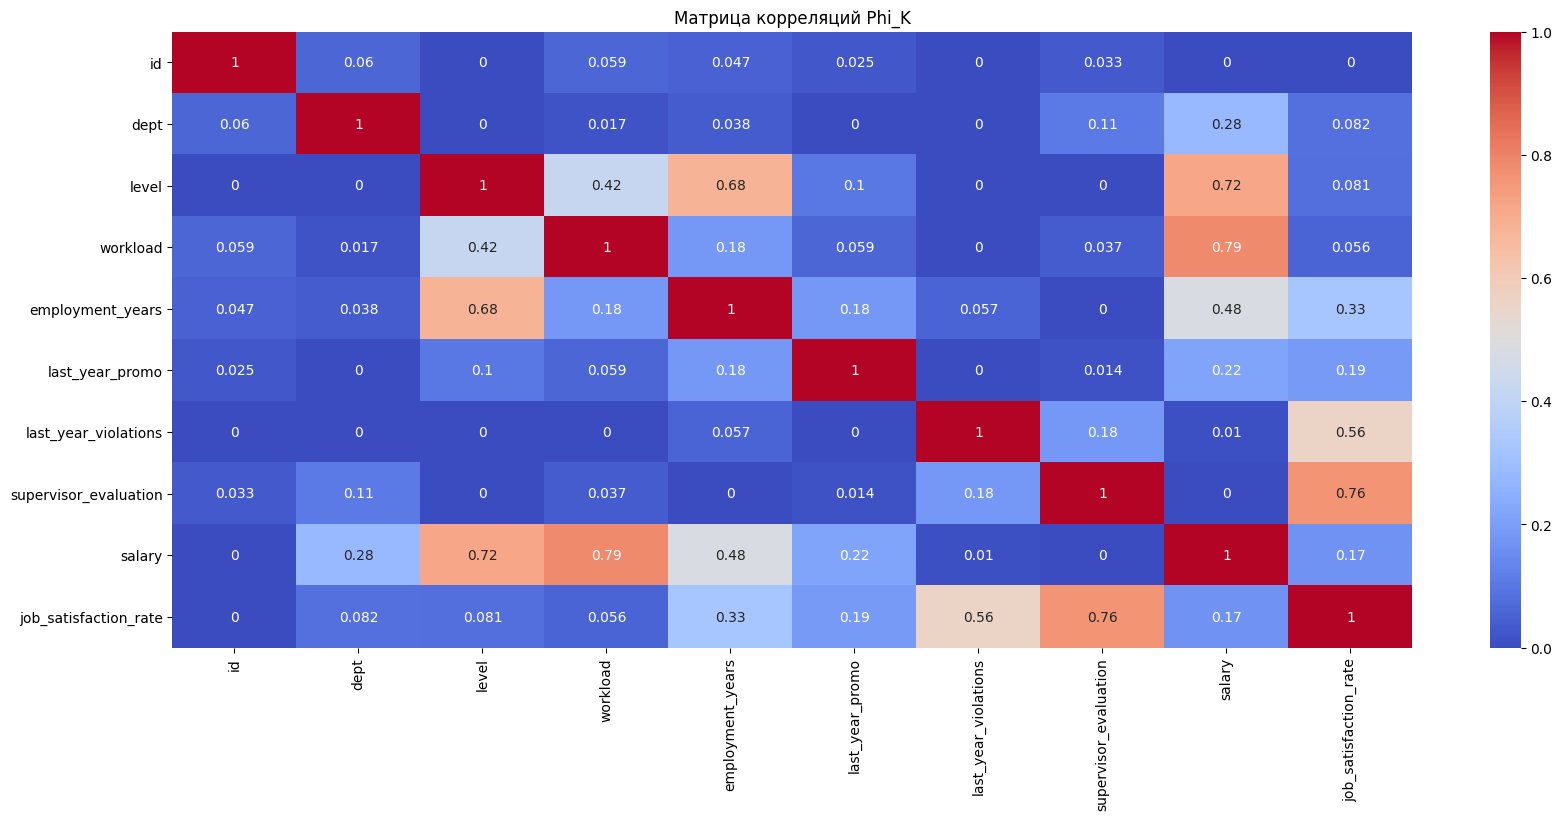

In [20]:
interval_columns=  ['id','employment_years','supervisor_evaluation','salary','job_satisfaction_rate']
corr_matrix = train_job_satisfaction_rate_data.phik_matrix(interval_cols=interval_columns)

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Phi_K')
plt.show()

**Вывод: так как значения в матрице корреляции < 0,9 можно говорить об отсутствии мультиколлинеарности. Набольшее влияние на значение целевого признака оказывают признаки last_year_violations (нарушал ли сотрудник трудовой договор за последний год) и supervisor_evaluation (оценка качества работы сотрудника, которую дал руководитель) что представляется логичным. Можно было бы ожидать большего влияния признака last_year_promo (было ли повышение за последний год), но этот признак проигрывает общей длительности работы в компании (employment_years)**

## 1.4 Подготовка данных

Объединим таблицы с исходными тестовыми данными и целевым признаком, иначе мы не сможем корректно оценить метрику модели

In [21]:
test_features_data= test_features_data.merge(test_target_job_satisfaction_rate_data, on='id')
test_features_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


Задаем тестовые и тренировочные выборки, RANDOM_STATE

Сначала удалим id из тренировочной выборки

In [22]:
X_train= train_job_satisfaction_rate_data.drop(['job_satisfaction_rate', 'id'], axis=1)

In [23]:
X_train.duplicated().sum()

1492

Проверим тренировочную таблицу для обучения на наличие полных дубликатов и запомним в отдельной таблице дубликаты чтоб удалить их также из выборки с целевым признаком

In [24]:
df_duplicated = X_train[X_train.duplicated(keep='first')]
print(df_duplicated.shape)
df_duplicated.head()

(1492, 8)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
77,technology,junior,low,1,no,no,4,19200
80,sales,junior,medium,2,no,no,3,26400
159,technology,middle,medium,8,no,no,4,40800
174,hr,junior,low,1,no,no,4,13200
190,sales,junior,low,1,no,no,5,12000


Удалим полные дубликаты

In [25]:
X_train= X_train.drop_duplicates()
print(X_train.shape)
X_train.duplicated().sum()

(2508, 8)


0

Сделаем выборку с целевым признаком и удалим из нее по индексу элементы, удаленные из входных признаков

In [26]:
y_train= train_job_satisfaction_rate_data['job_satisfaction_rate']
y_train=y_train[~y_train.index.isin(df_duplicated.index)]
y_train.shape

(2508,)

In [27]:
RANDOM_STATE = 42

X_test= test_features_data.drop(['job_satisfaction_rate', 'id'], axis=1)

y_test= test_features_data['job_satisfaction_rate']

X_test.shape, y_test.shape

((2000, 8), (2000,))

Проверим наборы данных для моделирования

In [28]:
X_train.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [29]:
X_test.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,marketing,junior,medium,2,no,no,5,28800
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
4,hr,middle,medium,5,no,no,5,40800


In [30]:
y_train.head()

0    0.58
1    0.76
2    0.11
3    0.37
4    0.20
Name: job_satisfaction_rate, dtype: float64

In [31]:
y_test.head()

0    0.79
1    0.72
2    0.64
3    0.60
4    0.75
Name: job_satisfaction_rate, dtype: float64

Создаём списки категориальных признаков: для OneHotEncoder отберем признаки с небольшим количеством значений, так как на каждое значение энкодер создает свой столбец

In [32]:
ord_columns =  ['dept', 'level', 'workload']
ohe_columns =  ['last_year_promo', 'last_year_violations']

создаём список численных признаков 

In [34]:
num_columns= ['employment_years','supervisor_evaluation','salary']

создаём пайплайн для подготовки признаков

In [35]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и кодирование
# OHE
ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и OrdinalEncoder-кодирование
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

## 1.5 Обучение моделей

In [36]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', [StandardScaler(), MinMaxScaler(), 'passthrough'], num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [37]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,30),
        'models__min_samples_leaf': range(2,30),
        'models__min_samples_split': range(2,30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression(
        )],
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


Добавим в pipeline собственную метрику и настроим инструменты перебора гиперпараметров моделей

In [38]:
# создаём функцию для оценки качества модели
def smape_metric(y_true, y_pred):
    # вычисляем метрику
    numerator= np.abs(y_true- y_pred)
    denominator= (np.abs(y_pred) + np.abs(y_true))/2
    return 100 * np.mean(numerator / denominator)

# создаём пользовательскую метрику
scorer = make_scorer(smape_metric, greater_is_better=False) 

cv_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise',
    n_iter=100
)
cv_search.fit(X_train, y_train)

print('Лучшая модель:\n\n', cv_search.best_estimator_)
print ('Параметры лучшей модели:', cv_search.best_params_)
print ('Метрика SMAPE лучшей модели на кросс-валидации:', -1*cv_search.best_score_)

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                   

In [39]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = cv_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape_metric(y_test, y_test_pred)}')

Метрика SMAPE на тестовой выборке: 13.796823179856975


Проанализируем остатки модели

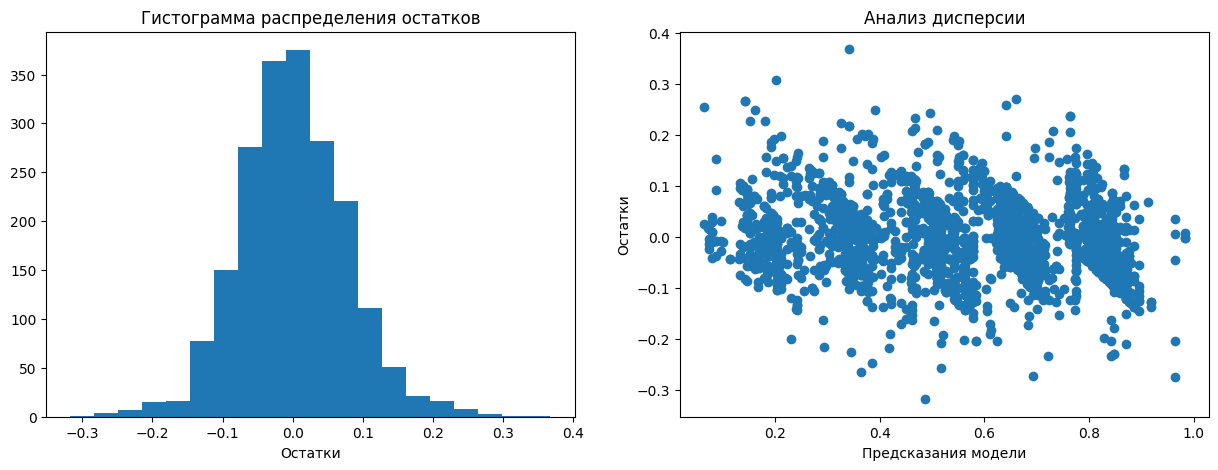

In [40]:
residuals = y_test - y_test_pred
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(x=residuals, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
 
axes[1].scatter(x=y_test_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Анализ распределения остатков: остатки распределены симметрично, распределение по форме близко к нормальному, заметных выбросов нет. Анализ дисперсии показывает, что данные обладают более-менее  свойством гомоскедастичности (дисперсия более-менее постоянна вдоль прямой).

## 1.6 Промежуточные выводы

**Вывод: лучший результат показала модель DecisionTreeRegressor (дерево решений) с параметрами max_depth=25, min_samples_leaf=4, min_samples_split=3. Анализ остатков показывает,что остатки распределены симметрично, распределение по форме близко к нормальному, заметных выбросов нет. Дисперсия остатков более-менее обладает свойством гомоскедастичности (дисперсия более-менее постоянна вдоль прямой). Показатель целевой метрики SMAPE на тестовой выборке = 13.79, что удовлетворяет критерию успеха задачи.**

## Задача 2 Предсказание увольнения сотрудника из компании

<b>Исходные данные</b>: тренировочная выборка train_quit.csv, входные признаки тестовой выборки (те же, что и в прошлой задаче test_features_data), целевой признак тестовой выборки test_target_quit.csv

## 2.1 Загрузка данных

In [41]:
train_quit_data= pd.read_csv(datasets_path+'train_quit.csv', sep=',')
test_target_quit_data= pd.read_csv(datasets_path+'test_target_quit.csv', sep=',')

##  2.2 Предобработка данных

Выведем общую информацию и первые 5 строк файла train_quit_data.csv для контроля загрузки и первого знакомства с данными

In [42]:
print(train_quit_data.info())
train_quit_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Выведем общую информацию и первые 5 строк файла test_target_quit.csv для контроля загрузки и первого знакомства с данными

In [43]:
print(test_target_quit_data.info())
test_target_quit_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Пропусков в данных нет**

#### Поиск явных дубликатов

In [44]:
train_quit_data.duplicated().sum()

0

In [45]:
test_target_quit_data.duplicated().sum()

0

**Вывод: явные дубликаты не найдены**

#### Поиск неявных дубликатов для значений, заданных строками-перечислениями

In [46]:
print('train_quit_data:')
for column in train_quit_data.select_dtypes(exclude='number').columns.tolist():
    print(f'{column}:{sorted(train_quit_data[column].unique())}')

train_quit_data:
dept:['hr', 'marketing', 'purchasing', 'sales', 'technology']
level:['junior', 'middle', 'sinior']
workload:['high', 'low', 'medium']
last_year_promo:['no', 'yes']
last_year_violations:['no', 'yes']
quit:['no', 'yes']


In [47]:
print('test_target_quit_data:')
for column in test_target_quit_data.select_dtypes(exclude='number').columns.tolist():
    print(f'{column}:{sorted(test_target_quit_data[column].unique())}')

test_target_quit_data:
quit:['no', 'yes']


**Неявных дубликатов нет**

## 2.3 Исследовательский анализ данных

#### Изучим числовые характеристики исходных данных о сотрудниках

In [48]:
train_quit_data.describe() 

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


Сделаем срез данных по уволненным сотрудникам для анализа

In [49]:
train_quit_data_yes= train_quit_data[train_quit_data['quit']=='yes']
train_quit_data_yes.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


**Анализ распределения значений числовых признаков, характеризующих сотрудников**

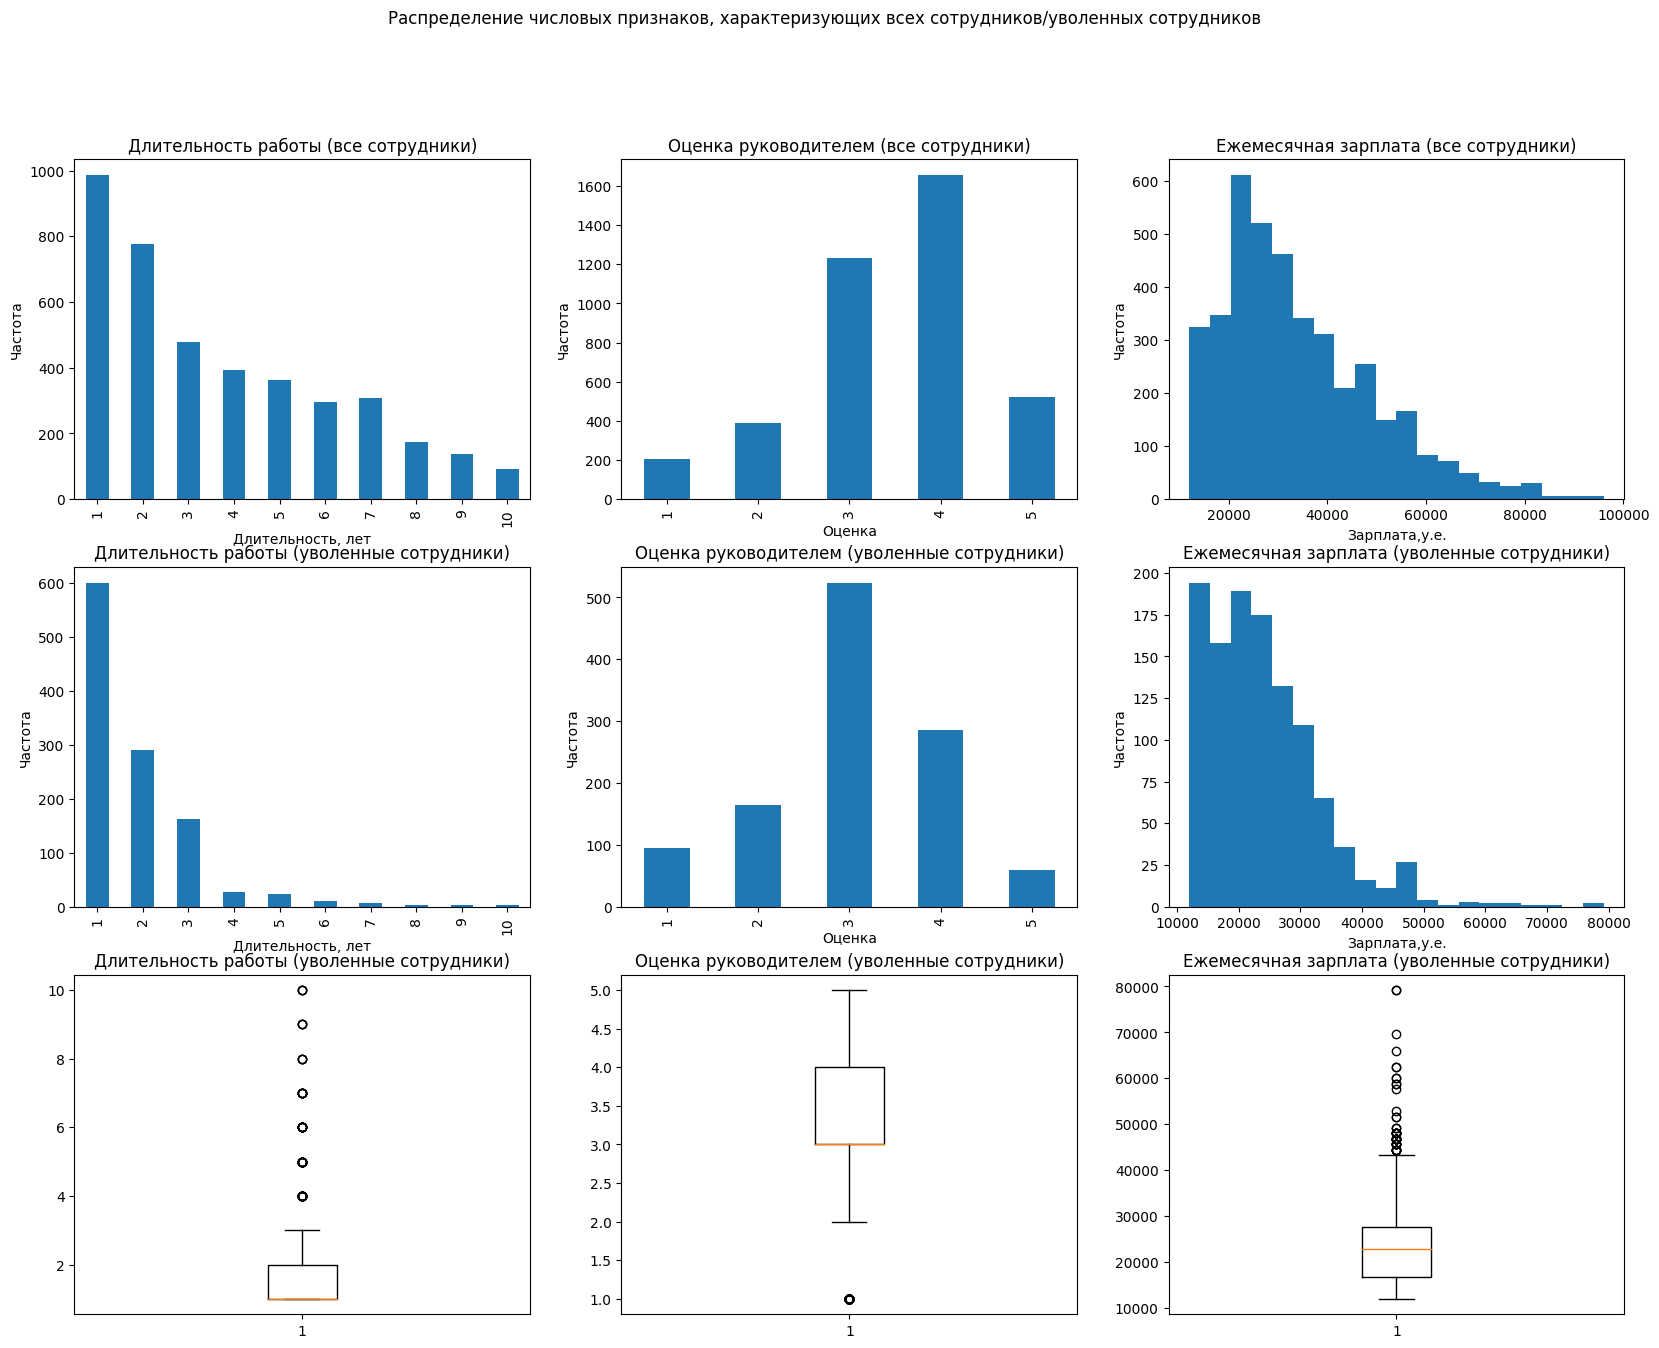

In [50]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Распределение числовых признаков, характеризующих всех сотрудников/уволенных сотрудников')
train_quit_data.groupby('employment_years')['employment_years'].count().plot(
ax=ax1,
kind='bar',
title='Длительность работы (все сотрудники)')
ax1.set_ylabel('Частота')
ax1.set_xlabel('Длительность, лет')
train_quit_data.groupby('supervisor_evaluation')['supervisor_evaluation'].count().plot(
ax=ax2,
kind='bar',
title='Оценка руководителем (все сотрудники)')
ax2.set_ylabel('Частота')
ax2.set_xlabel('Оценка')
train_quit_data['salary'].plot(
ax=ax3,
bins=20,
kind='hist',
title='Ежемесячная зарплата (все сотрудники)')
ax3.set_ylabel('Частота')
ax3.set_xlabel('Зарплата,у.е.')
train_quit_data_yes.groupby('employment_years')['employment_years'].count().plot(
ax=ax4,
kind='bar',
title='Длительность работы (уволенные сотрудники)')
ax4.set_ylabel('Частота')
ax4.set_xlabel('Длительность, лет')
train_quit_data_yes.groupby('supervisor_evaluation')['supervisor_evaluation'].count().plot(
ax=ax5,
kind='bar',
title='Оценка руководителем (уволенные сотрудники)')
ax5.set_ylabel('Частота')
ax5.set_xlabel('Оценка')
train_quit_data_yes['salary'].plot(
ax=ax6,
bins=20,
kind='hist',
title='Ежемесячная зарплата (уволенные сотрудники)')
ax6.set_ylabel('Частота')
ax6.set_xlabel('Зарплата,у.е.')
ax7.boxplot(train_quit_data_yes['employment_years'])
ax8.boxplot(train_quit_data_yes['supervisor_evaluation'])
ax9.boxplot(train_quit_data_yes['salary']) 
ax7.set_title('Длительность работы (уволенные сотрудники)')
ax8.set_title('Оценка руководителем (уволенные сотрудники)')
ax9.set_title('Ежемесячная зарплата (уволенные сотрудники)')
plt.show()

#### Изучим категориальные характеристики исходных данных о сотрудниках

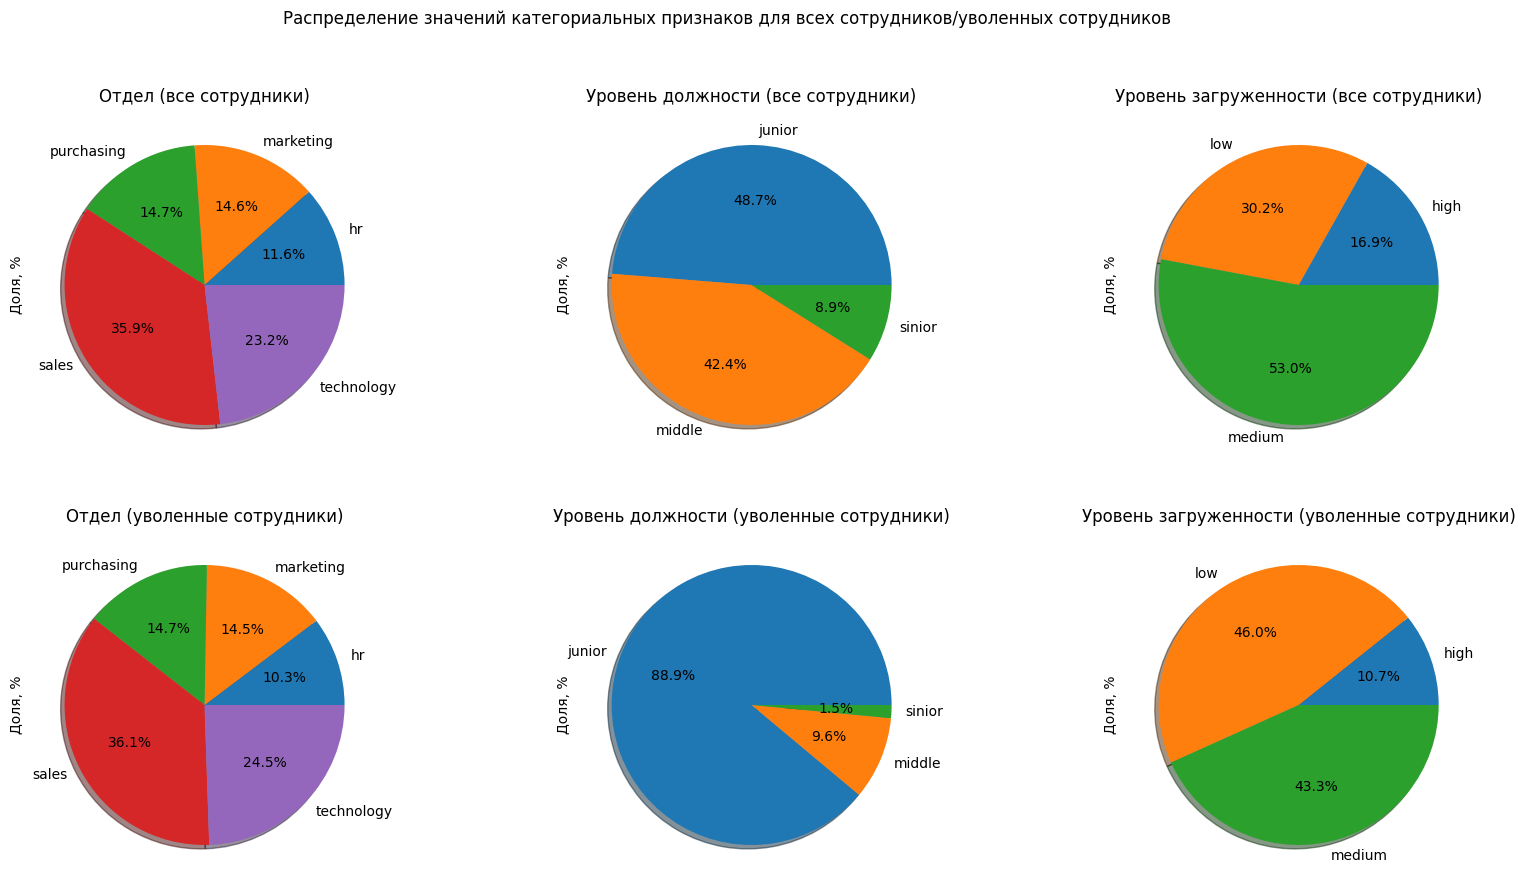

In [51]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Распределение значений категориальных признаков для всех сотрудников/уволенных сотрудников')
train_quit_data.groupby('dept')['dept'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Отдел (все сотрудники)')
train_quit_data.groupby('level')['level'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень должности (все сотрудники)')
train_quit_data.groupby('workload')['workload'].count().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень загруженности (все сотрудники)')
train_quit_data_yes.groupby('dept')['dept'].count().plot(
ax=ax4,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Отдел (уволенные сотрудники)')
train_quit_data_yes.groupby('level')['level'].count().plot(
ax=ax5,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень должности (уволенные сотрудники)')
train_quit_data_yes.groupby('workload')['workload'].count().plot(
ax=ax6,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Уровень загруженности (уволенные сотрудники)')
plt.show()

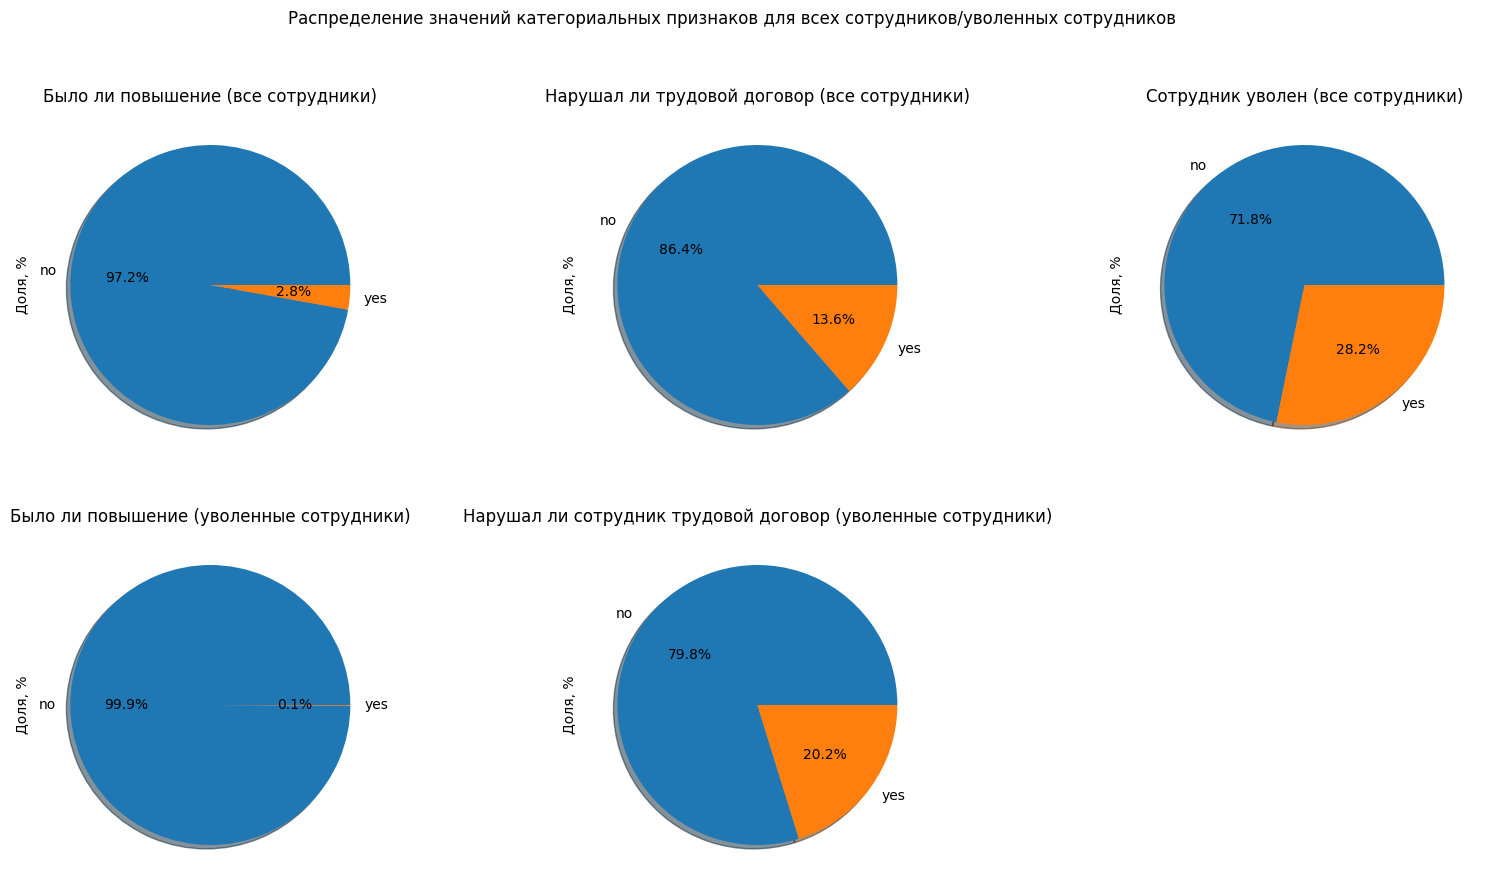

In [52]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Распределение значений категориальных признаков для всех сотрудников/уволенных сотрудников')
train_quit_data.groupby('last_year_promo')['last_year_promo'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Было ли повышение (все сотрудники)')
train_quit_data.groupby('last_year_violations')['last_year_violations'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Нарушал ли трудовой договор (все сотрудники)')
train_quit_data.groupby('quit')['quit'].count().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Сотрудник уволен (все сотрудники)')
train_quit_data_yes.groupby('last_year_promo')['last_year_promo'].count().plot(
ax=ax4,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Было ли повышение (уволенные сотрудники)')
train_quit_data_yes.groupby('last_year_violations')['last_year_violations'].count().plot(
ax=ax5,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Нарушал ли сотрудник трудовой договор (уволенные сотрудники)')
ax6.set_visible(False)
plt.show()

Построим матрицу корреляции чтобы выяснить, какие признаки имеют наибольшую взаимосвязь с целевым признаком "quit"

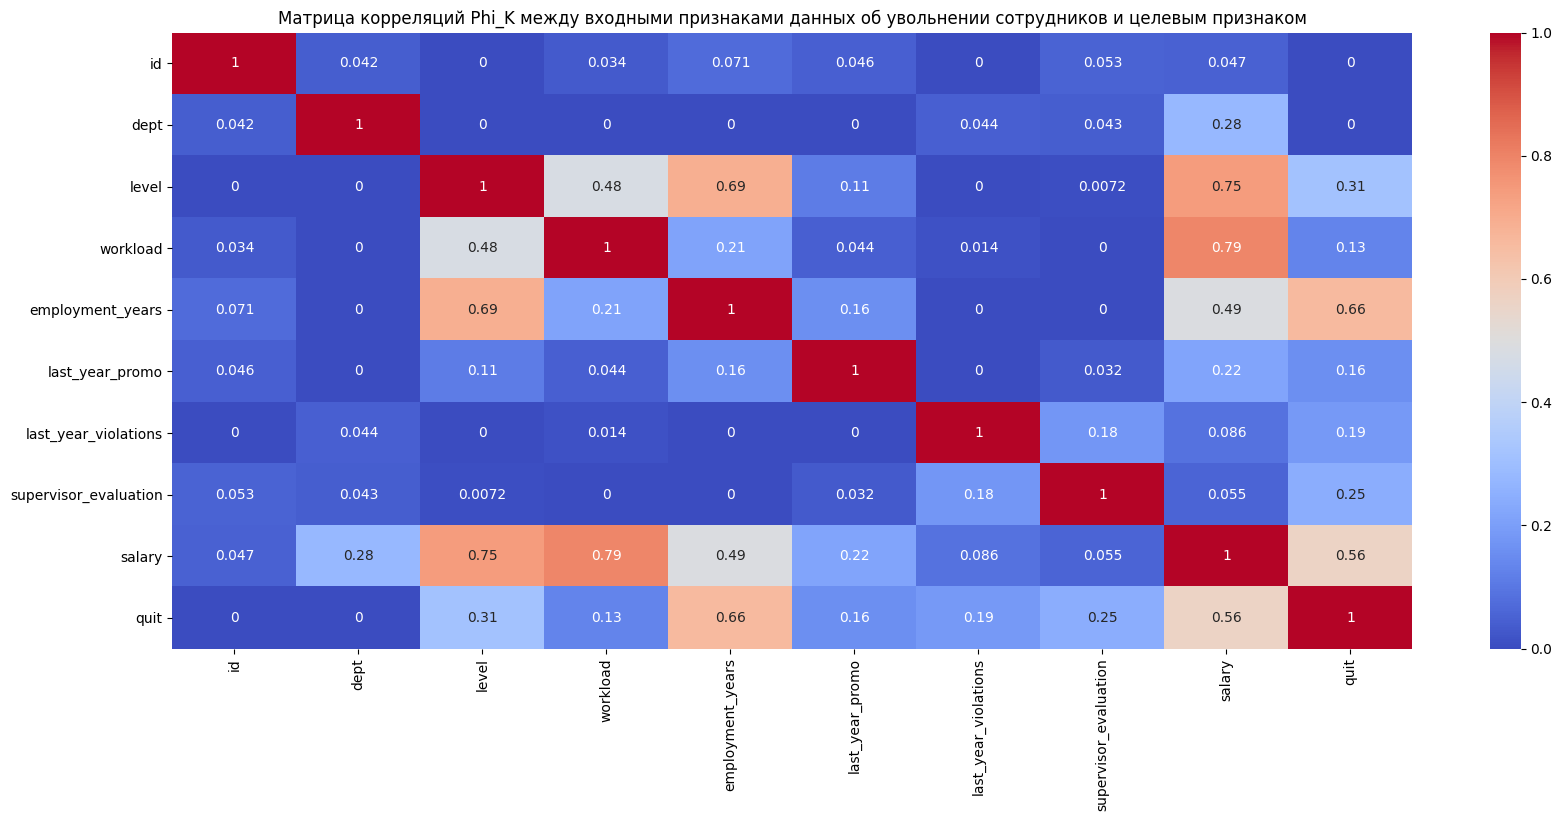

In [53]:
interval_columns=  ['id','employment_years','supervisor_evaluation','salary']
corr_matrix = train_quit_data.phik_matrix(interval_cols=interval_columns)

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Phi_K между входными признаками данных об увольнении сотрудников и целевым признаком')
plt.show()

Объединим данные об уровне удовлетворенности сотрудников и данные об увольнении чтобы проверить, влияет ли уровень удовлетворенности на то, уволится ли сотрудник

In [54]:
print(test_target_job_satisfaction_rate_data.shape)
test_target_job_satisfaction_rate_data= test_target_job_satisfaction_rate_data.merge(test_target_quit_data, on='id')
print(test_target_job_satisfaction_rate_data.shape)
test_target_job_satisfaction_rate_data.head()

(2000, 2)
(2000, 3)


,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


Построим матрицу корреляции между признаками удовлетворенности и увольнения

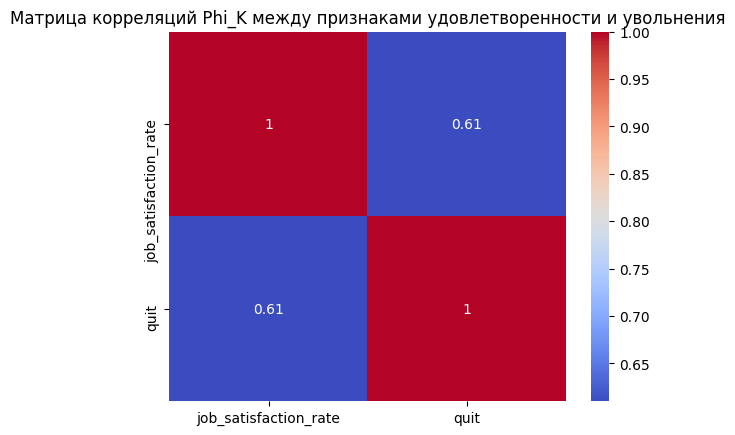

In [55]:
interval_columns=  ['job_satisfaction_rate']
corr_matrix = test_target_job_satisfaction_rate_data.drop(['id'], axis=1).phik_matrix(interval_cols=interval_columns)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Phi_K между признаками удовлетворенности и увольнения')
plt.show()

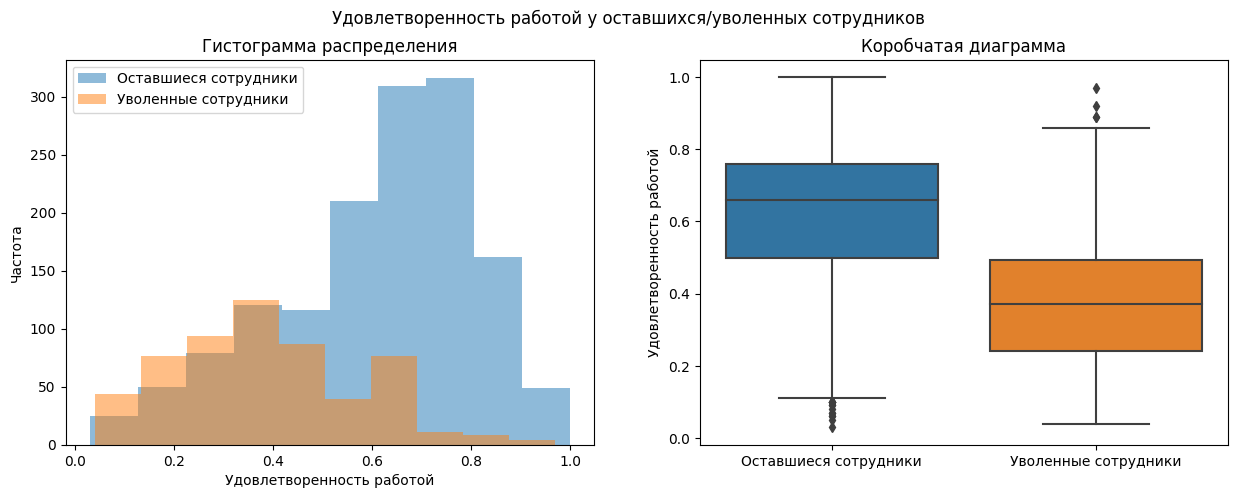

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Удовлетворенность работой у оставшихся/уволенных сотрудников')
test_target_job_satisfaction_rate_data.groupby('quit')['job_satisfaction_rate'].plot(
ax=ax1,
kind='hist',
title='Гистограмма распределения',
alpha=0.5)
ax1.set_ylabel('Частота')
ax1.set_xlabel('Удовлетворенность работой')
ax1.legend(['Оставшиеся сотрудники', 'Уволенные сотрудники'])
sf_data=test_target_job_satisfaction_rate_data.groupby('quit')
sns.boxplot(
ax=ax2,
x='quit', 
y='job_satisfaction_rate', 
data=test_target_job_satisfaction_rate_data)
ax2.set_xlabel('')
ax2.set_ylabel('Удовлетворенность работой')
ax2.set_xticklabels(["Оставшиеся сотрудники","Уволенные сотрудники"])
ax2.set_title('Коробчатая диаграмма')
plt.show()


Проверим тренировочную таблицу для обучения на наличие полных дубликатов и запомним в отдельной таблице дубликаты чтоб удалить их также из выборки с целевым признаком

In [57]:
df_duplicated = X_train[X_train.duplicated(keep='first')]
print(df_duplicated.shape)
df_duplicated.head()

(0, 8)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


Удалим полные дубликаты

In [58]:
X_train= X_train.drop_duplicates()
print(X_train.shape)
X_train.duplicated().sum()

(2508, 8)


0

Сделаем выборку с целевым признаком и удалим из нее по индексу элементы, удаленные из входных признаков

In [59]:
y_train= train_job_satisfaction_rate_data['job_satisfaction_rate']
y_train=y_train[~y_train.index.isin(df_duplicated.index)]
y_train.shape

(4000,)

**Вывод: уволившийся сотрудник может быть из любого отдела (взаимосвязь почти нулевая), работал с большой вероятностью не более 3,5 лет, занимал в большинстве случаев должности начального уровня (большинство - junior), за крайне редким исключением не получал повышения, зарплату получал среднюю и ниже. Связь загрузки сотрудника с увольнением довольно низкая, чаще всего увольнялись сотрудники с низкой загрузкой, но скорее всего это просто потому, что она и предполагалась уровнем занимаемой должности (прежде всего -junior). Уволенный сотрудник нарушал трудовой договор чуть чаще среднего по компании, оценивался руководителем чаще всего средне. Отличающиеся от описанного портрета высокооплачиваемые и долго работающие сотрудники увольнялись редко. Между уровнем удовлетворенности и увольнением определенно есть сильная взаимосвязь.Уволилось 28% сотрудников, о которых были предоставлены данные, при этом уровень удовлетворенности работой уволенных в среднем составлял 0,4, тогда как для оставшихся уровень удовлетворенности в среднем выше 0,6.**

## 2.4 Добавление нового входного признака

Объединим таблицы с исходными тестовыми данными и целевым признаком, иначе мы не сможем корректно оценить метрику модели

In [60]:
test_features_data= test_features_data.merge(test_target_quit_data, on='id')
test_features_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


Подготовим базовые наборы данных для моделирования

In [61]:
X_train= train_quit_data.drop(['quit', 'id'], axis=1)
X_test= test_features_data.drop(['quit', 'id'], axis=1)
y_train= train_quit_data['quit']
y_test= test_features_data['quit']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 8), (2000, 9), (4000,), (2000,))

Проверим наборы данных, в том числе тренировочный набор данных на наличие дубликатов, которые могли появиться после уменьшения числа признаков

In [62]:
print(f'Дубликатов в тренировочной выборке: {X_train.duplicated().sum()}')

Дубликатов в тренировочной выборке: 1545


In [63]:
df_duplicated = X_train[X_train.duplicated(keep='first')]
print(df_duplicated.shape)
df_duplicated.head()

(1545, 8)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
65,marketing,junior,medium,1,no,no,4,24000
68,sales,middle,low,5,no,no,4,24000
117,technology,junior,medium,2,no,no,4,31200
144,sales,middle,low,5,no,no,4,19200
152,sales,middle,low,8,no,no,4,19200


Удалим полные дубликаты из тренировочной выборки

In [64]:
X_train= X_train.drop_duplicates()
print(f'Размер выборки входных признаков: {X_train.shape}')
print(f'Дубликатов в тренировочной выборке: {X_train.duplicated().sum()}')

Размер выборки входных признаков: (2455, 8)
Дубликатов в тренировочной выборке: 0


Удалим из тренировочной выборки целевого признака по индексу элементы, удаленные из входных признаков

In [65]:
y_train=y_train[~y_train.index.isin(df_duplicated.index)]
print(f'Размер выборки целевого признака: {y_train.shape}')

Размер выборки целевого признака: (2455,)


In [66]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.79
1,hr,junior,medium,1,no,no,4,30000,0.72
2,sales,middle,low,5,no,no,4,19200,0.64
3,sales,middle,low,6,no,no,4,19200,0.60
4,hr,middle,medium,5,no,no,5,40800,0.75


In [67]:
y_train.head()

0     no
1     no
2     no
3    yes
4     no
Name: quit, dtype: object

In [68]:
y_test.head()

0    no
1    no
2    no
3    no
4    no
Name: quit, dtype: object

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

In [69]:
X_train['job_satisfaction_rate']= cv_search.predict(X_train)
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.635000
1,sales,junior,medium,2,no,no,4,27600,0.825000
2,purchasing,middle,medium,5,no,no,1,37200,0.386000
3,sales,junior,medium,2,no,yes,3,24000,0.360000
4,marketing,junior,medium,2,no,no,5,25200,0.806667


In [70]:
X_test['job_satisfaction_rate']= cv_search.predict(X_test)
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.856667
1,hr,junior,medium,1,no,no,4,30000,0.641429
2,sales,middle,low,5,no,no,4,19200,0.664286
3,sales,middle,low,6,no,no,4,19200,0.664286
4,hr,middle,medium,5,no,no,5,40800,0.742500


## 2.5 Подготовка данных

In [71]:
num_columns= ['employment_years','supervisor_evaluation','salary','job_satisfaction_rate']

In [72]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и кодирование
# OHE
ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)
# создаём пайплайн для подготовки признаков из списка ord_columns: OrdinalEncoder-кодирование
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Используем LabelEncoder для кодирования целевого признака

In [73]:
print('y_train до кодирования:', y_train.tolist()[:5])
# создадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучим модель и трансформируем тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

print('y_train после кодирования:', y_train.tolist()[:5])

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

print('y_test после кодирования:', y_test[:5])

y_train до кодирования: ['no', 'no', 'no', 'yes', 'no']
y_train после кодирования: [0, 0, 0, 1, 0]
y_test после кодирования: [0 0 0 0 0]


## 2.6 Обучение модели

In [74]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', [StandardScaler(), MinMaxScaler(), 'passthrough'], num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [75]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,5),
        'models__max_features': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 5),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE
        )],
        'models__kernel': ['linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [76]:
cv_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
cv_search.fit(X_train, y_train)

print('Лучшая модель:\n\n', cv_search.best_estimator_)
print ('Параметры лучшей модели:', cv_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', cv_search.best_score_)


# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = cv_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                   

Результат на тестовой выборке уже удовлетворяет поставленному в задаче значению метрики (>0,91 на тестовой выборке). Но попробуем еще улучшить метрику отбором признаков

Отложим значения коэффициентов лучшей модели, полученной в результате подбора параметров, на графике

feature_names: ['ohe__last_year_promo_yes' 'ohe__last_year_violations_yes' 'ord__dept'
 'ord__level' 'ord__workload' 'num__employment_years'
 'num__supervisor_evaluation' 'num__salary' 'num__job_satisfaction_rate']


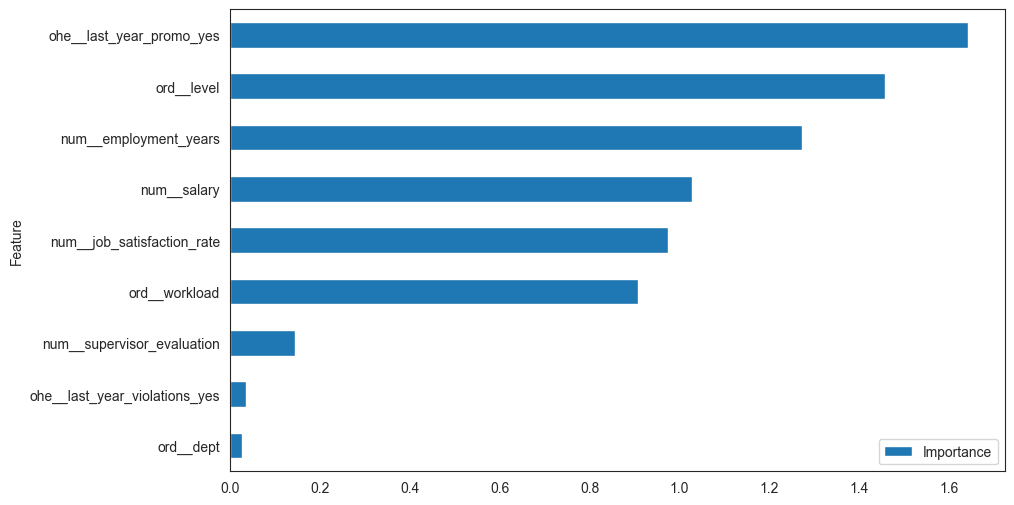

In [77]:
feature_names= cv_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
print(f'feature_names: {feature_names}')
model= cv_search.best_estimator_.named_steps['models']
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance',ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Отбор в цикле признаков от самых важных, добавляя менее важные

Features count: 1
Featues: ['ohe__last_year_promo_yes']
Метрика ROC-AUC: 0.5182317904344218
Features count: 2
Featues: ['ohe__last_year_promo_yes', 'ord__level']
Метрика ROC-AUC: 0.7643177463007962
Features count: 3
Featues: ['ohe__last_year_promo_yes', 'ord__level', 'num__employment_years']
Метрика ROC-AUC: 0.8133834380371007
Features count: 4
Featues: ['ohe__last_year_promo_yes', 'ord__level', 'num__employment_years', 'num__salary']
Метрика ROC-AUC: 0.8351409549773801
Features count: 5
Featues: ['ohe__last_year_promo_yes', 'ord__level', 'num__employment_years', 'num__salary', 'num__job_satisfaction_rate']
Метрика ROC-AUC: 0.9045022619964835
Features count: 6
Featues: ['ohe__last_year_promo_yes', 'ord__level', 'num__employment_years', 'num__salary', 'num__job_satisfaction_rate', 'ord__workload']
Метрика ROC-AUC: 0.917016708153065
Features count: 7
Featues: ['ohe__last_year_promo_yes', 'ord__level', 'num__employment_years', 'num__salary', 'num__job_satisfaction_rate', 'ord__workload', 

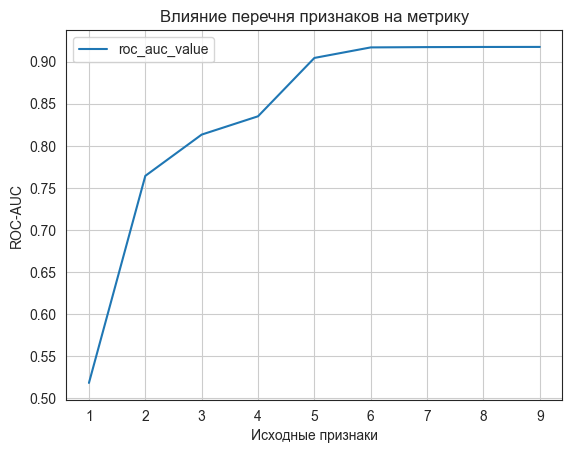


Максимальное значение метрики ROC-AUC=0.9175859114166618


In [78]:
all_features_names=feature_importance.sort_values('Importance',ascending=False)['Feature'].tolist()

X_train_transformed = pd.DataFrame(cv_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train),columns = feature_names)
X_test_transformed =  pd.DataFrame(cv_search.best_estimator_.named_steps['preprocessor'].transform(X_test),columns = feature_names)

max_roc_auc_value=-1
features_metric = []
features_cnt=len(all_features_names)
for i in range(features_cnt):
    print(f'Features count: {i+1}')
    selected_features_names = all_features_names[0:i+1]
    # отберем данные
    X_train_new = X_train_transformed[list(selected_features_names)]
    X_test_new = X_test_transformed[list(selected_features_names)]
    
    # инициализируем и обучаем модель
    model.fit(X_train_new, y_train)
    
    y_test_pred = model.predict_proba(X_test_new)[:,1]
    print(f'Featues: {selected_features_names}')
    roc_auc_value=roc_auc_score(y_test, y_test_pred)
    features_metric.append(tuple((len(selected_features_names), selected_features_names, roc_auc_value)))
    if roc_auc_value>max_roc_auc_value:
        max_roc_auc_value= roc_auc_value
    print(f'Метрика ROC-AUC: {roc_auc_value}')
features_metric_data =  pd.DataFrame(features_metric, columns = ['features_cnt', 'feature_names', 'roc_auc_value'])
features_metric_data.plot(
    title='Влияние перечня признаков на метрику',
    kind='line',
    x='features_cnt',
    y='roc_auc_value',
    xlabel='Исходные признаки',
    ylabel='ROC-AUC',
    grid=True
)
plt.show()
print(f'\nМаксимальное значение метрики ROC-AUC={max_roc_auc_value}')

Видно, что начиная с 6 самых важных признаков значение метрики практически не улучшается. Поэтому, чтобы минимизировать количество признаков (исходя из улучшения быстродействия модели) можно взять 6 признаков.Выведем эти признаки

In [79]:
optimal_features= features_metric_data[features_metric_data['features_cnt']==6]['feature_names'].tolist()
print(f'Оптимальный с точки зрения соотношения метрики (ROC-AUC={round(max_roc_auc_value,4)}) и производительности набор признаков:\n{optimal_features}')

Оптимальный с точки зрения соотношения метрики (ROC-AUC=0.9176) и производительности набор признаков:
[['ohe__last_year_promo_yes', 'ord__level', 'num__employment_years', 'num__salary', 'num__job_satisfaction_rate', 'ord__workload']]


Добавим полиномиальные признаки в цикле, начиная с самых важных, постепенно добавляя менее важные и расчитаем значение Roc-auc на каждом шаге

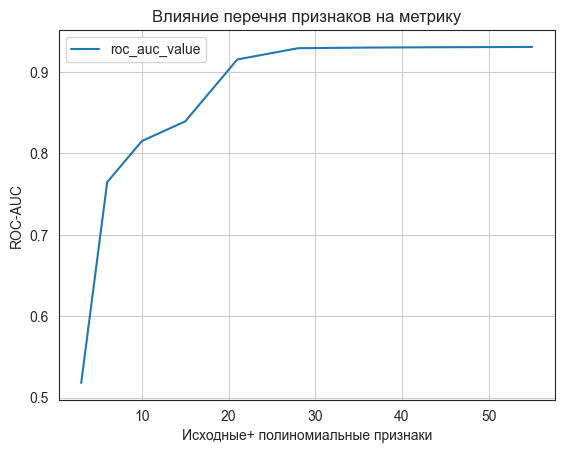

Максимальное значение метрики ROC-AUC=0.930641779766491
Улучшение по сравнению с отбором без полиномиальных признаков=0.013055868349829192


In [80]:
X_train_transformed = pd.DataFrame(cv_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train),columns = feature_names)
X_test_transformed =  pd.DataFrame(cv_search.best_estimator_.named_steps['preprocessor'].transform(X_test),columns = feature_names)

features_metric = []
features_cnt=len(all_features_names)
for i in range(features_cnt):
    # отберем данные
    selected_features_names = all_features_names[0:i+1]
    # отберем данные и добавим полиномиальные признаки
    X_train_new = X_train_transformed[list(selected_features_names)]
    X_test_new = X_test_transformed[list(selected_features_names)]
    
    poly = PolynomialFeatures(2)

    X_train_poly = pd.DataFrame(poly.fit_transform(X_train_new),columns = poly.get_feature_names_out())
    step_columns= poly.get_feature_names_out()
    X_test_poly = pd.DataFrame(poly.transform(X_test_new),columns = step_columns)
     
    scaler = StandardScaler()
    # стандартизация
    X_train_new = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = step_columns)
    X_test_new =  pd.DataFrame(scaler.transform(X_test_poly),columns = step_columns)
    
    # инициализируем и обучаем модель
    model.fit(X_train_new, y_train)
    
    y_test_pred = model.predict_proba(X_test_new)[:,1]
    roc_auc_value= roc_auc_score(y_test, y_test_pred)
    features_metric.append(tuple((len(step_columns), step_columns, roc_auc_value)))
features_metric_data =  pd.DataFrame(features_metric, columns = ['features_cnt', 'feature_names', 'roc_auc_value'])
features_metric_data.plot(
    title='Влияние перечня признаков на метрику',
    kind='line',
    x='features_cnt',
    y='roc_auc_value',
    xlabel='Исходные+ полиномиальные признаки',
    ylabel='ROC-AUC',
    grid=True
)
plt.show()
print(f'Максимальное значение метрики ROC-AUC={features_metric_data["roc_auc_value"].max()}')
print(f'Улучшение по сравнению с отбором без полиномиальных признаков={features_metric_data["roc_auc_value"].max()-max_roc_auc_value}')

В результате добавления полиномиальных признаков метрика качества возросла незначительно. Аналогично, если все-таки использовать полиномиальные признаки, для баланса качества и производительности можно взять 25 признак. Далее при добавлении признаков улучшения метрики практически не происходит. Выведем эти признаки

In [81]:
optimal_features= features_metric_data[features_metric_data['features_cnt']==25]['feature_names'].tolist()
roc_auc_value= features_metric_data[features_metric_data['features_cnt']==25]['roc_auc_value'].to_string(index=False)
print(f'Оптимальный с точки зрения соотношения метрики (ROC-AUC={roc_auc_value}) и производительности набор признаков: {optimal_features}')

Оптимальный с точки зрения соотношения метрики (ROC-AUC=Series([], )) и производительности набор признаков: []


Попробуем отобрать признаки с добавлением полиномиальных инструментом SelectKBest

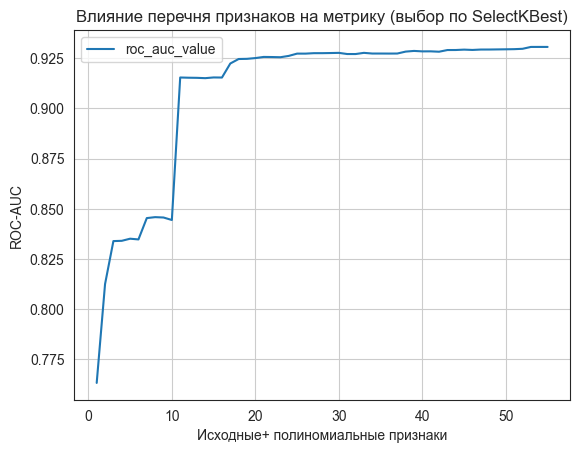

Максимальное значение метрики ROC-AUC=0.9306442491949662
Улучшение по сравнению с отбором без полиномиальных признаков=0.013058337778304452


In [82]:
np.seterr(divide='ignore', invalid='ignore')

scaler = StandardScaler()
poly = PolynomialFeatures(2)

X_train_poly = pd.DataFrame(poly.fit_transform(X_train_transformed),columns = poly.get_feature_names_out())
poly_columns= poly.get_feature_names_out()
X_test_poly = pd.DataFrame(poly.transform(X_test_transformed),columns = poly_columns)

# стандартизация
X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = poly_columns)
X_test_scalled =  pd.DataFrame(scaler.transform(X_test_poly),columns = poly_columns)

best_metric_val=-1
best_feature_params=''
best_feature_names=''
features_metric = []
for i in range(len(X_test_poly.columns)):
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scalled, y_train)

    features_names = selector.get_feature_names_out()
    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]
    # инициализируем и обучаем модель
    model.fit(X_train_new, y_train)
    
    y_test_pred = model.predict_proba(X_test_new)[:,1]
    roc_auc_val= roc_auc_score(y_test, y_test_pred)
    feature_params=selector.get_params()
    features_metric.append(tuple((len(features_names), features_names, feature_params , roc_auc_val)))
    
features_metric_data =  pd.DataFrame(features_metric, columns = ['features_cnt', 'feature_names', 'feature_params' , 'roc_auc_value'])
features_metric_data.plot(
    title='Влияние перечня признаков на метрику (выбор по SelectKBest)',
    kind='line',
    x='features_cnt',
    y='roc_auc_value',
    xlabel='Исходные+ полиномиальные признаки',
    ylabel='ROC-AUC',
    grid=True
)
plt.show()
print(f'Максимальное значение метрики ROC-AUC={features_metric_data["roc_auc_value"].max()}')
print(f'Улучшение по сравнению с отбором без полиномиальных признаков={features_metric_data["roc_auc_value"].max()-max_roc_auc_value}')

По графику видно, что наибольший рост метрики происходит в районе 11 признаков, далее после 17 признаков улучшение незначительно. С точки зрения затрат на моделирование (а особенно на подготовку исходных данных, которое может включать анкетирование сотрудников и т.д.) стоит ограничиться этим набором признаков. Выведем его

In [83]:
optimal_features= features_metric_data[features_metric_data['features_cnt']==17]['feature_names'].tolist()
roc_auc_value= features_metric_data[features_metric_data['features_cnt']==17]['roc_auc_value'].to_string(index=False)
print(f'Оптимальный с точки зрения соотношения метрики (ROC-AUC={roc_auc_value}) и производительности набор признаков:\n {optimal_features}')

Оптимальный с точки зрения соотношения метрики (ROC-AUC=0.92238) и производительности набор признаков:
 [array(['ord__level', 'num__employment_years',
       'num__supervisor_evaluation', 'num__salary',
       'num__job_satisfaction_rate',
       'ohe__last_year_violations_yes num__employment_years',
       'ohe__last_year_violations_yes num__salary',
       'ord__dept ord__level', 'ord__dept num__employment_years',
       'ord__dept num__salary', 'ord__dept num__job_satisfaction_rate',
       'ord__level^2', 'ord__level ord__workload',
       'ord__workload num__employment_years', 'ord__workload num__salary',
       'ord__workload num__job_satisfaction_rate',
       'num__employment_years num__job_satisfaction_rate'], dtype=object)]


## 2.7 Промежуточный вывод

<b>Лучшие показатели получены у модели логистической регрессии с параметрами 
(C=3, penalty='l1', random_state=42, solver='liblinear').Метрика ROC-AUC на тестовой выборке= 0.919, 
что удовлетворяет критерию успеха ROC-AUC=>0.91, заданному в ТЗ. Отбор признаков позволяет сделать вывод, 
что наиболее значимыми для принятия решения моделью являются признаки  
'длительность работы в компании', "уровень загруженности сотрудник, "ежемесячная зарплата"а" и добавленный в результате моделировани 
с использованием первой модели признак "уровень удовлетворенности сотрудника". 
При этоь получено значение метрики ROC-AUC=0.9 на тестовой выборке, которое удовлетворяет критерию успеха, заданному в ТЗ. За счет добавления полиномиальных признаков значение метрики может быть повышено до ROC-AUC=0,93, но и затраты ресурсов на моделирование возрастут.</b>08

## Общий вывод

<b>В работе решены две задачи:</b>
<ol>
    <li>Построена модель, которая может предсказать уровень удовлетворённости сотрудника на основе данных заказчика.</li>
    <li>Построена модель, которая может на основе данных заказчика предсказать то, что сотрудник уволится из компании</li>
</ol>  
   <b>Подробнее о проделанной работе:</b>
<ol>
    <li>На этапе предобработки данных выявлено, что данные об отделе, в котором работает сотрудник, и уровне занимаемой должности могут содержать пропуски. Они автоматически обрабатываются моделью в блоке подготовки данных</li>
    <li>При подготовке данных использовались кодировщики категориальных признаков в числовые, а также методы масштабирования и нормализации числовых данных</li>
    <li>Подготовка данных и обучение первой модели осуществлялся в пайплайне с использованием кросс-валидации, в качестве моделей выбраны дерево решений и линейная регрессия. В качестве целевой метрики SMAPE («симметричное среднее абсолютное процентное отклонение»). Для модели дерева решений в автоматическом режиме подбирались гиперпараметры, минимизирующие значение метрики.</li>
    <li>Лучший результат показала модель DecisionTreeRegressor (дерево решений) с параметрами max_depth=25, min_samples_leaf=4, min_samples_split=3. Ограничения на гиперпараметры для кросс-валидации подобраны вручную с решением задачи нахождения компромисса между минимизацией целевого признака на тренировочной и тестовой выборке и требованием к гомоскедастичности дисперсии остатков для выбранной модели. Показатель целевой метрики SMAPE на тестовой выборке = 13.79, что удовлетворяет критерию успеха задачи.</li>
    <li>На этапе решения второй задачи построен портрет уволившегося сотрудника: уволившийся сотрудник может быть из любого отдела (взаимосвязь почти нулевая), работал с большой вероятностью не более 3,5 лет, занимал в большинстве случаев должности начального уровня (большинство - junior), за крайне редким исключением не получал повышения, зарплату получал среднюю и ниже. Связь загрузки сотрудника с увольнением довольно низкая, чаще всего увольнялись сотрудники с низкой загрузкой, но скорее всего это просто потому, что она и предполагалась уровнем занимаемой должности (прежде всего -junior). Уволенный сотрудник нарушал трудовой договор чуть чаще среднего по компании, оценивался руководителем чаще всего средне. Отличающиеся от описанного портрета высокооплачиваемые и долго работающие сотрудники увольнялись редко.Уволилось 28% сотрудников, о которых были предоставлены данные. Между уровнем удовлетворенности и увольнением определенно есть сильная взаимосвязь: уровень удовлетворенности работой уволенных в среднем составлял 0,4, тогда как для оставшихся уровень удовлетворенности в среднем выше 0,6.</li>
    <li>Подготовка данных и обучение второй модели осуществлялся в пайплайне с использованием кросс-валидации, в качестве моделей выбраны дерево решений, логистическая регрессия, модель KNN, модель SVC (метод опорных векторов). В качестве целевой метрики выбрана ROC-AUC. Для всех моделей в автоматическом режиме подбирались гиперпараметры, минимизирующие значение метрики.</li>
    <li>Лучшие показатели получены у модели логистической регрессии с параметрами (C=3, penalty='l1', random_state=42, solver='liblinear'). Метрика ROC-AUC на тестовой выборке: 0.919, что удовлетворяет критерию успеха ROC-AUC=>0.91, заданному в ТЗ. Отбор признаков позволяет сделать вывод, что наиболее значимыми для принятия решения моделью являются признаки "было ли повышение", 'уровень занимаемой должности', 'длительность работы в компании', "уровень загруженности сотрудника", "ежемесячная зарплата" и добавленный в результате моделирования с использованием первой модели признак "уровень удовлетворенности сотрудника". При этом может быть получено значение метрики ROC-AUC=0.919, которое может быть улучшено за счет добавления полиномиальных признаков  (до ROC-AUC=0.93)</li>
</ol> 
<b>Выводы и дополнительные предложения для бизнеса:</b>
<p>"Портрет уволенного сотрудника" выявил, что большинство увольнений - у недавно работающих сотрудников на должностях начального уровня. Возможно, "молодые" сотрудники не видят для себя места в компании в будущем, и стоит попытаться заинтересовать их перспективами (большая оплата труда, более интересная и высоквалифицированная работа после обучения и тп).</p>
</b>